In [1]:
!pip install medmnist

In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/


## Load and visualize bloodmnist

In [4]:
#data_flag = 'bloodmnist'
#data_flag = 'pneumoniamnist'
data_flag = 'pathmnist'

download = True

BATCH_SIZE = 128

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

In [5]:
# preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)

train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

Using downloaded and verified file: /Users/emtzhou/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/emtzhou/.medmnist/pathmnist.npz
Using downloaded and verified file: /Users/emtzhou/.medmnist/pathmnist.npz


In [6]:
# visualization
train_dataset.montage(length=1)

/opt/anaconda3/lib/python3.9/site-packages/medmnist/utils.py:31: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


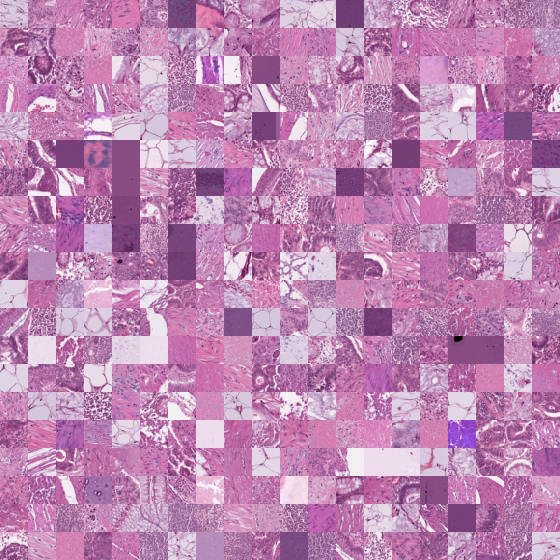

In [7]:
# visualize 20x20 images
train_dataset.montage(length=20)

## Train

In [8]:
# define model
class Net(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(Net, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU())

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU())

        self.layer5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))

        self.fc = nn.Sequential(
            nn.Linear(64 * 4 * 4, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes))

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [9]:
# train and test function
def train(model, data_loader, ep, device='cpu'):
    model.train()
    loss_all = 0
    num_correct, num_all, auc_train = 0, 0, 0
    data_loader_tqdm = tqdm(data_loader, ncols=100)
    for inputs, targets in data_loader_tqdm:
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = model(inputs)

        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_all += loss.item() * targets.shape[0]
        pred_class = torch.argmax(outputs, dim=1)
        num_correct += torch.sum(pred_class == targets)
        num_all += targets.shape[0]
        data_loader_tqdm.set_description('Epoch %d, loss %.3f, train acc %.3f' %
         (ep, loss_all / num_all, num_correct / num_all))

    return num_correct / num_all


def test(split, model, device='cpu'):
    model.eval()
    y_true = torch.tensor([], device=device)
    y_score = torch.tensor([], device=device)

    if split == 'train':
        data_loader = train_loader
    elif split == 'val':
        data_loader = val_loader
    else:
        data_loader = test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.detach().cpu().numpy()
        y_score = y_score.detach().cpu().numpy()

        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)

        print('%s auc: %.3f  acc:%.3f' % (split, *metrics))

In [ ]:
# parameters
num_epochs = 30
lr = 0.001
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# criterion
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()

# model
model = Net(in_channels=n_channels, num_classes=n_classes).to(device)

# optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=lr)

for epoch in range(num_epochs):
    # train
    model.train()
    train(model=model, data_loader=train_loader, ep=epoch, device=device)

    # validation
    print('==> Evaluating ...')
    model.eval()
    test('val', model=model, device=device)

# test
print('==> Testing ...')
test('test', model=model, device=device)

Epoch 0, loss 0.570, train acc 0.793: 100%|███████████████████████| 704/704 [01:43<00:00,  6.81it/s]


==> Evaluating ...
val auc: 0.987  acc:0.816


Epoch 1, loss 0.329, train acc 0.883: 100%|███████████████████████| 704/704 [01:41<00:00,  6.94it/s]


==> Evaluating ...
val auc: 0.993  acc:0.897


Epoch 2, loss 0.252, train acc 0.911: 100%|███████████████████████| 704/704 [01:50<00:00,  6.40it/s]


==> Evaluating ...
val auc: 0.993  acc:0.863


Epoch 3, loss 0.212, train acc 0.926: 100%|███████████████████████| 704/704 [01:44<00:00,  6.77it/s]


==> Evaluating ...
val auc: 0.995  acc:0.913


Epoch 4, loss 0.189, train acc 0.934: 100%|███████████████████████| 704/704 [01:42<00:00,  6.86it/s]


==> Evaluating ...
val auc: 0.995  acc:0.906


Epoch 5, loss 0.169, train acc 0.941: 100%|███████████████████████| 704/704 [01:50<00:00,  6.36it/s]


==> Evaluating ...
val auc: 0.995  acc:0.900


Epoch 6, loss 0.153, train acc 0.946: 100%|███████████████████████| 704/704 [02:01<00:00,  5.79it/s]


==> Evaluating ...
val auc: 0.983  acc:0.775


Epoch 7, loss 0.143, train acc 0.950: 100%|███████████████████████| 704/704 [01:55<00:00,  6.10it/s]


==> Evaluating ...
val auc: 0.998  acc:0.943


Epoch 8, loss 0.127, train acc 0.955: 100%|███████████████████████| 704/704 [01:50<00:00,  6.40it/s]


==> Evaluating ...
val auc: 0.996  acc:0.918


Epoch 9, loss 0.117, train acc 0.960: 100%|███████████████████████| 704/704 [01:52<00:00,  6.24it/s]


==> Evaluating ...
val auc: 0.989  acc:0.821


Epoch 10, loss 0.119, train acc 0.959: 100%|██████████████████████| 704/704 [01:51<00:00,  6.30it/s]


==> Evaluating ...
val auc: 0.998  acc:0.939


Epoch 11, loss 0.098, train acc 0.965: 100%|██████████████████████| 704/704 [01:55<00:00,  6.07it/s]


==> Evaluating ...
val auc: 0.997  acc:0.943


Epoch 12, loss 0.095, train acc 0.967: 100%|██████████████████████| 704/704 [01:52<00:00,  6.27it/s]


==> Evaluating ...
val auc: 0.996  acc:0.915


Epoch 13, loss 0.091, train acc 0.968: 100%|██████████████████████| 704/704 [02:11<00:00,  5.37it/s]


==> Evaluating ...
val auc: 0.993  acc:0.895


Epoch 14, loss 0.082, train acc 0.971: 100%|██████████████████████| 704/704 [01:55<00:00,  6.11it/s]


==> Evaluating ...
val auc: 0.998  acc:0.939


Epoch 15, loss 0.079, train acc 0.972: 100%|██████████████████████| 704/704 [01:45<00:00,  6.68it/s]


==> Evaluating ...
val auc: 0.998  acc:0.929


Epoch 16, loss 0.064, train acc 0.977:  78%|█████████████████     | 546/704 [01:22<00:23,  6.67it/s]